TypeError: 'in <string>' requires string as left operand, not NoneType

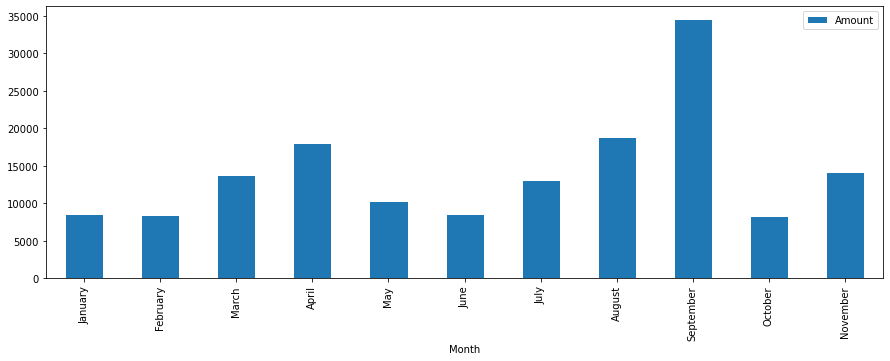

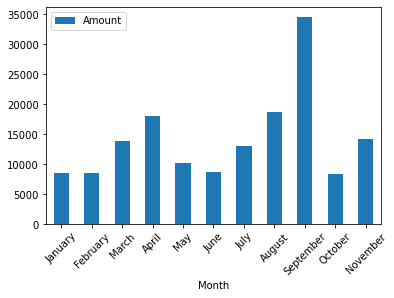

In [5]:
import sys
import pandas as pd
import numpy as np

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import pyplot as plt, dates
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

import PySimpleGUI as sg
import os.path

import pymongo

sg.theme("DarkBlue14")
sg.set_options(font=("Arial 16"), text_color="white")

data_entry_column = [
        [sg.Text("Name"), sg.Push(), sg.I(size=(30,3), key="NAME")],
        #[sg.CalendarButton(button_text="Date", format="%d-%m-%y", no_titlebar=True, close_when_date_chosen=True, 
        #default_date_m_d_y=(1,1,2022)), sg.Push(), sg.I(size=(30,3), key="DATE")],
        [sg.Text("Month"), sg.Push(), sg.Combo(size=(29,3), values=["January","February","March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"], key="MONTH")],
        [sg.Text("Expense Type"), sg.Push(), sg.Combo(size=(29,3), values=["Grocery","Transport","Other"], key="EXPENSE")],
        [sg.Text("Amount"), sg.Push(), sg.I(size=(30,3), key="AMOUNT")],
        [sg.Button("Submit", expand_x=True), sg.Button("Clear", expand_x=True), sg.Button("Exit", expand_x=True),
        sg.Button("Retrieve", expand_x=True), sg.Button("Delete", expand_x=True)],   
]

data_viewer_column = [
    #[sg.Text("Choose Parameters to Plot:")],
    #[sg.Text("X Axis:")],
    #[sg.Text("Name"), sg.Push(), sg.I(size=(30,3), key="NAME")],
    #[sg.Text("Month"), sg.Push(), sg.Combo(size=(29,3), values=["January","February","March", "April", "May", "June",
    #"July", "August", "September", "October", "November", "December"], key="MONTH")],
    #[sg.Text("Expense Type"), sg.Push(), sg.Combo(size=(29,3), values=["Grocery","Transport","Other"], key="EXPENSE")],
    #[sg.Text("Y Axis:")],
    #[sg.Text("Amount"), sg.Push(), sg.I(size=(30,3), key="AMOUNT")],
    [sg.Text("Expense Plot:")],
    [sg.Button("Plot", expand_x=True)],
    [sg.Canvas(key='-PLOT01-')],
]


layout=[
        [sg.Column(data_entry_column), sg.VSeperator(), sg.Column(data_viewer_column)]
]


window = sg.Window("Expense Record App", layout)


def clear_inputs():
    for key in values:
        window["NAME"].update("")
        window["MONTH"].update("")
        window["EXPENSE"].update("")
        window["AMOUNT"].update("")
    return None

while True:
    event, values = window.read()

    if event in (sg.WIN_CLOSED or "Exit"):
        break
        
    if event == "Clear":
        clear_inputs()
        
    if event == "Retrieve":
        client = pymongo.MongoClient("mongodb://localhost:27017/")
        database = client["Household_Expenses"]
        collection = database["Year2022"]
        for x in collection.find({"Name":values["NAME"], "Month": values["MONTH"],"Expense Type": values["EXPENSE"]}):
            window['AMOUNT'].update(value=x["Amount"])
            #print(x["Amount"])
            
    if event == "Delete":
        client = pymongo.MongoClient("mongodb://localhost:27017/")
        database = client["Household_Expenses"]
        collection = database["Year2022"]
        collection.delete_one({"Name":values["NAME"], "Month": values["MONTH"]})
            #print(x["Transport"])
            
    if event == "Submit":
        name=values["NAME"]
        if name == "":
            sg.PopupError("Missing name", "Please insert name")
        month=values["MONTH"]
        if month == "":
            sg.PopupError("Missing month", "Please insert month")
        expense=values["EXPENSE"]
        if expense == "":
            sg.PopupError("Missing expense", "Please insert expense")
        amount=values["AMOUNT"]
        if amount == "":
            sg.PopupError("Missing amount", "Please insert amount")
        else:
            try:
                summary_list = "The following information has been added to the database: "
                na ="\nName: " + values["NAME"]
                summary_list += na
                mo ="\nMnth: " + values["MONTH"]
                summary_list += mo
                ex ="\nExpense Type: " + values["EXPENSE"]
                summary_list += ex
                am ="\nAmount: " + values["AMOUNT"]
                summary_list += am
                choice = sg.PopupOKCancel(summary_list, "Please confirm entry.")
                if choice == "OK":
                    clear_inputs()
                    client = pymongo.MongoClient("mongodb://localhost:27017/")
                    database = client["Household_Expenses"]
                    collection = database["Year2022"]
                    documents = { "Name": values["NAME"], "Month": values["MONTH"],
                    "Expense": values["EXPENSE"], "Amount": int(values["AMOUNT"]) }
                    
                    x = collection.insert_one(documents)
                    #for x in collection.find({}):
                        #print(x)

                    sg.PopupQuick("Succesfully saved to database.")
                else:
                    sg.PopupOK("Edit entry")
            except:
                sg.Popup("There is an error, contact Admin")
        
    if event == "Plot":
        client = pymongo.MongoClient("mongodb://localhost:27017/")
        database = client["Household_Expenses"]
        collection = database["Year2022"]
        df = pd.DataFrame(list(database["Year2022"].find()))
        df3 = pd.DataFrame(df.groupby(['Month'])['Amount'].sum())
        df3 = df3.reset_index()
        month_dict = {"January":1,"February":2,"March":3, "April":4, "May":5, "June":6,
        "July":7, "August":8, "September":9, "October":10, "November":11, "December":12}
        #print(df3)
        #fig, axs = plt.subplots(1 , 1, figsize=(8, 6), constrained_layout=True)
        df4 = df3.sort_values('Month', key = lambda x: x.apply (lambda x : month_dict[x]))
        df4.plot(x='Month', kind = 'bar', figsize=(15,5), edgecolor='white')
        ax = df4.plot.bar(x='Month',rot=45)
        fig = ax.get_figure()
        canvas = window['-PLOT01-'].TKCanvas
        figure_canvas_agg = FigureCanvasTkAgg(fig, canvas)
        figure_canvas_agg.draw() 
        figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)

window.close()